# MVPA MEG Tutorial (Matlab): Distance measures and cross-validation

[Tutorial starting page](https://github.com/m-guggenmos/megmvpa/).

This tutorial accompanies the preprint titled "Multivariate pattern analysis for MEG: a comprehensive comparison of dissimilarity measures", which is available at [doi.org/10.1101/172619](https://doi.org/10.1101/172619).

**Goal of this tutorial:** comparison of Euclidean and Pearson distance measures + cross-validation.

## Tutorial

We set a seed, in order to make analyses reproducible:

In [1]:
rng(10);

Let's load some data:

In [2]:
root = ''; % This is the /path/to the directory containing the data.
           % We leave it empty here, because the data is located in the current directory.

% Load data and trial labels for the two sessions of participant 01

% Session 1
load(fullfile(root, 'data01_sess1.mat'));
load(fullfile(root, 'labels01_sess1.mat'));
sessions(1).data = data01_sess1;
sessions(1).labels = labels01_sess1;
% Session 2
load(fullfile(root, 'data01_sess2.mat'));
load(fullfile(root, 'labels01_sess2.mat'));
sessions(2).data = data01_sess2;
sessions(2).labels = labels01_sess2;

Now we set some parameters. Only the number of permutations and the number of pseudo-trials are free parameters. The number of conditions, sensors, time points and sessions are derived from the data (i.e., from the `sessions` variable above).

In [3]:
% Parameters
n_perm = 20;  % number of permutations
n_pseudo = 5;  % number of pseudo-trials
n_conditions = length(unique(sessions(1).labels));
n_sensors = size(sessions(1).data, 2);
n_time = size(sessions(1).data, 3);
n_sessions = length(sessions);

### Non-cross-validated distances

We start with computing non-cross-validated distances (`ec` and `ps`). For this, the analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 3 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Apply distance measure to the data

In [5]:
% pre-load mechanism, for convenience
preload_result = true; % for recomputing the decoding analyses, set to false
if preload_result
    load(fullfile(root, 'result_distance.mat'))
else
    clfs = {'ec', 'ps'};
    for c = 1:length(clfs)
        result.(clfs{c}) = nan(n_sessions, n_perm, n_conditions, n_conditions, n_time);
    end
    for s = 1:n_sessions

        fprintf('Session %g / %g\n', s, n_sessions)

        X = sessions(s).data;
        y = sessions(s).labels;
        
        conditions = unique(y);
        n_trials = histc(y, conditions);

        for f = 1:n_perm
            fprintf('\tPermutation %g / %g\n', f, n_perm)
            
            % precompute permutations
            ind_pseudo = nan(n_conditions, n_conditions, 2*n_pseudo);
            labels_pseudo = nan(n_conditions, n_conditions, 2*n_pseudo);
            for c1 = 1:n_conditions
                range_c1 = (c1-1)*n_pseudo+1:c1*n_pseudo;
                for c2 = 1:n_conditions
                    range_c2 = (c2-1)*n_pseudo+1:c2*n_pseudo;
                    ind_pseudo(c1, c2, 1:2*n_pseudo) = [range_c1 range_c2];
                    labels_pseudo(c1, c2, 1:2*n_pseudo) = ...
                        [conditions(c1)*ones(1, n_pseudo) conditions(c2)*ones(1, n_pseudo)];
                end
            end         
            
            test_indices = cell(1, n_conditions*n_pseudo);
            for c1 = 1:n_conditions  % separate permutation for each class
                prm_ = randperm(n_trials(c1));                
                prm = cell(1, n_pseudo);
                splitsize = n_trials(c1) / n_pseudo;
                for i = 1:n_pseudo
                    idxs = floor(round((i-1)*splitsize)):floor(round((i)*splitsize))-1;
                    prm{i} = prm_(idxs + 1);
                end                                
                ind = cellfun(@(x)x+sum(n_trials(1:c1-1)), prm, 'UniformOutput', 0);
                xrange = (c1-1)*n_pseudo+1:c1*n_pseudo;
                for i = 1:length(xrange)
                    test_indices{xrange(i)} = ind{i};
                end
            end
            
            % 1. Compute pseudo-trials for training and test
            Xpseudo = nan(length(test_indices), n_sensors, n_time);
            for i = 1:length(test_indices)
                Xpseudo(i, :, :) = mean(X(test_indices{i}, :, :), 1);
            end

            % 2. Whitening using the Epoch method
            sigma_conditions = reshape(squeeze(labels_pseudo(1, :, n_pseudo+1:end))', 1, []);
            sigma_ = nan(n_conditions, n_sensors, n_sensors);
            for c = 1:n_conditions
                % compute sigma for each time point, then average across time
                tmp_ = nan(n_time, n_sensors, n_sensors);
                for t = 1:n_time
                    tmp_(t, :, :) = covCor(Xpseudo(sigma_conditions==c, :, t));
                end
                sigma_(c, :, :) = mean(tmp_, 1);
            end
            sigma = squeeze(mean(sigma_, 1));  % average across conditions
            sigma_inv = sigma^-0.5;
            for t = 1:n_time
                Xpseudo(:, :, t) = squeeze(Xpseudo(:, :, t)) * sigma_inv;
            end

            for t = 1:n_time
                for c1 = 1:n_conditions-1
                    for c2 = c1+1:n_conditions                        
                        % 3. Apply distance measure to the data
                        data = Xpseudo(ind_pseudo(c1, c2, :), :, t);
                        y = squeeze(labels_pseudo(c1, c2, :));
                        classes = unique(y);
                        result.ec(s, f, c1, c2, t) = pdist2(mean(data(y==classes(1), :), 1),...
                                                            mean(data(y==classes(2), :), 1),...
                                                            'squaredeuclidean');
                        result.ps(s, f, c1, c2, t) = pdist2(mean(data(y==classes(1), :), 1),...
                                                            mean(data(y==classes(2), :), 1),...
                                                            'correlation');
                    end
                end
            end
        end
    end
    % average across permutations
    for c = 1:length(clfs)
        result_.(clfs{c}) = nan(n_sessions, n_perm, n_conditions, n_conditions, n_time);
    end 
    result_.ec = squeeze(nanmean(result.ec, 2));
    result_.ps = squeeze(nanmean(result.ps, 2));
    result = result_;
    save(fullfile(root, 'result_distance.mat'), 'result')
end

To take a look at the results.

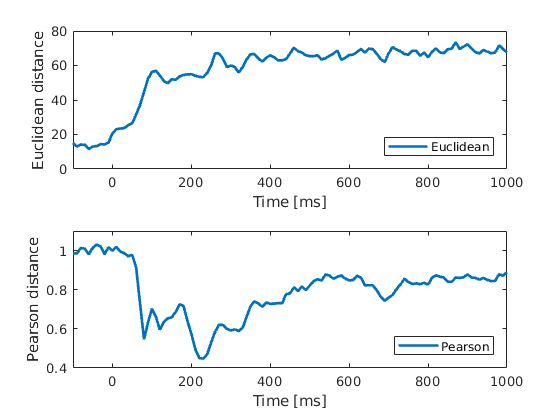

In [7]:
subplot(211)
plot(-100:10:1001, squeeze(nanmean(nanmean(nanmean(result.ec, 1), 2), 3)), 'linewidth', 2)
xlim([-100 1000])
xlabel('Time [ms]')
ylabel('Euclidean distance')
legend('Euclidean', 'location', 'SouthEast')

subplot(212)
plot(-100:10:1001, squeeze(nanmean(nanmean(nanmean(result.ps, 1), 2), 3)), 'linewidth', 2)
xlim([-100 1000])
ylim([0.4, 1.1])
xlabel('Time [ms]')
ylabel('Pearson distance')
legend('Pearson', 'location', 'SouthEast')

**Euclidean distance:** the Euclidean distance rises shortly after stimulus onset (at 0ms) and until it reaches a maximum. Interestingly, the distance remains at this maximum after stimulus offset (at 500ms) until the end of the epoch, although the condition-specific information content [drops to zero](https://github.com/m-guggenmos/megmvpa/blob/master/tutorial_matlab/matlab_decoding.ipynb) towards the end of the trial. This indicates that the non-cross-validated Euclidean distance is not only influenced by condition-specific differences in activation patterns, but also by noise.

**Pearson distance:** the Pearson distance _decreases_ after stimulus onset, corresponding to an increase of the correlation between condition-specific activation patterns (note that the Pearson distance is defined as 1−r). Thus, activation patterns in fact get more similar after stimulus onset, which intuitively seems surprising, since the [decoding analysis](https://github.com/m-guggenmos/megmvpa/blob/master/tutorial_matlab/matlab_decoding.ipynb) shows that they also get more distinct. In contrast to the Euclidean distance, the Pearson approaches its baseline value towards the end of the trial.

### Cross-validated distances

We now turn to cross-validated measures. Here too, the analytic logic is contained in a nested for loop, with loops for the number of sessions, number of permutations, number of timepoints, number of conditions, and number of conditions again. Overall, the logic contains 4 crucial steps:
1. Compute pseudo-trials for the training and test data
2. Whiten the training data (here using the Epoch method, which is recommended in our manuscript)
3. Apply distance measure to training data
4. Validate distance measure on testing data

In [8]:
% pre-load mechanism, for convenience
preload_result = true; % for recomputing the decoding analyses, set to false
if preload_result
    load(fullfile(root, 'result_distance_cv.mat'))
else
    clfs = {'ec_cv', 'ps_cv'};
    for c = 1:length(clfs)
        result_cv.(clfs{c}) = nan(n_sessions, n_perm, n_conditions, n_conditions, n_time);
    end
    for s = 1:n_sessions

        fprintf('Session %g / %g\n', s, n_sessions)

        X = sessions(s).data;
        y = sessions(s).labels;
        
        conditions = unique(y);
        n_trials = histc(y, conditions);

        for f = 1:n_perm
            fprintf('\tPermutation %g / %g\n', f, n_perm)
            
            % precompute permutations
            ind_pseudo_train = nan(n_conditions, n_conditions, 2*(n_pseudo-1));
            ind_pseudo_test = nan(n_conditions, n_conditions, 2);
            labels_pseudo_train = nan(n_conditions, n_conditions, 2*(n_pseudo-1));
            labels_pseudo_test = nan(n_conditions, n_conditions, 2);
            for c1 = 1:n_conditions
                range_c1 = (c1-1)*(n_pseudo-1)+1:c1*(n_pseudo-1);
                for c2 = 1:n_conditions
                    range_c2 = (c2-1)*(n_pseudo-1)+1:c2*(n_pseudo-1);
                    ind_pseudo_train(c1, c2, 1:2*(n_pseudo - 1)) = [range_c1 range_c2];
                    ind_pseudo_test(c1, c2, :) = [c1 c2];
                    labels_pseudo_train(c1, c2, 1:2*(n_pseudo - 1)) = ...
                        [conditions(c1)*ones(1, n_pseudo - 1) conditions(c2)*ones(1, n_pseudo - 1)];
                    labels_pseudo_test(c1, c2, :) = conditions([c1 c2]);
                end
            end              
            train_indices = cell(1, n_conditions*(n_pseudo-1));
            test_indices = cell(1, n_conditions);
            for c1 = 1:n_conditions  % separate permutation for each class
                prm_ = randperm(n_trials(c1));                
                prm = cell(1, n_pseudo);
                splitsize = n_trials(c1) / n_pseudo;
                for i = 1:n_pseudo
                    idxs = floor(round((i-1)*splitsize)):floor(round((i)*splitsize))-1;
                    prm{i} = prm_(idxs + 1);
                end                                
                ind = cellfun(@(x)x+sum(n_trials(1:c1-1)), prm, 'UniformOutput', 0);
                xrange = (c1-1)*(n_pseudo-1)+1:c1*(n_pseudo-1);
                for i = 1:length(xrange)
                    train_indices{xrange(i)} = ind{i};
                end
                test_indices{c1} = ind{end};
            end                                

            % 1. Compute pseudo-trials for training and test
            Xpseudo_train = nan(length(train_indices), n_sensors, n_time);
            Xpseudo_test = nan(length(test_indices), n_sensors, n_time);
            for i = 1:length(train_indices)
                Xpseudo_train(i, :, :) = mean(X(train_indices{i}, :, :), 1);
            end
            for i = 1:length(test_indices)
                Xpseudo_test(i, :, :) = mean(X(test_indices{i}, :, :), 1);
            end


            % 2. Whitening using the Epoch method
            sigma_conditions = reshape(squeeze(labels_pseudo_train(1, :, n_pseudo:end))', 1, []);
            sigma_ = nan(n_conditions, n_sensors, n_sensors);
            for c = 1:n_conditions
                % compute sigma for each time point, then average across time
                tmp_ = nan(n_time, n_sensors, n_sensors);
                for t = 1:n_time
                    tmp_(t, :, :) = covCor(Xpseudo_train(sigma_conditions==c, :, t));
                end
                sigma_(c, :, :) = mean(tmp_, 1);
            end
            sigma = squeeze(mean(sigma_, 1));  % average across conditions
            sigma_inv = sigma^-0.5;
            for t = 1:n_time
                Xpseudo_train(:, :, t) = squeeze(Xpseudo_train(:, :, t)) * sigma_inv;
                Xpseudo_test(:, :, t) = squeeze(Xpseudo_test(:, :, t)) * sigma_inv;
            end

            for t = 1:n_time
                for c1 = 1:n_conditions-1
                    for c2 = c1+1:n_conditions
                        % 3. Apply distance measure to training data
                        data_train = Xpseudo_train(ind_pseudo_train(c1, c2, :), :, t);
                        y_train = squeeze(labels_pseudo_train(c1, c2, :));
                        classes = unique(y_train);
                        % Euclidean
                        dist_train_ec = mean(data_train(y_train==classes(1), :), 1) - ...
                                        mean(data_train(y_train==classes(2), :), 1);
                        % Pearson
                        A1_ps = mean(data_train(y_train==classes(1), :), 1);
                        B1_ps = mean(data_train(y_train==classes(2), :), 1);
                        var_A1_ps = var(A1_ps);
                        var_B1_ps = var(B1_ps);
                        denom_noncv_ps = sqrt(var_A1_ps * var_B1_ps);

                        % 4. Validate distance measure on testing data
                        data_test = Xpseudo_test(ind_pseudo_test(c1, c2, :), :, t);
                        y_test = squeeze(labels_pseudo_test(c1, c2, :));
                        
                        % Euclidean
                        dist_test_ec = mean(data_test(y_test==classes(1), :), 1) - ...
                                       mean(data_test(y_test==classes(2), :), 1);
                        result_cv.ec_cv(s, f, c1, c2, t) = dot(dist_train_ec, dist_test_ec);
                        % Pearson
                        A2_ps = mean(data_test(y_test==classes(1), :), 1);
                        B2_ps = mean(data_test(y_test==classes(2), :), 1);
                        cov_a1b2_ps = getfield(cov(A1_ps, B2_ps), {2});
                        cov_b1a2_ps = getfield(cov(B1_ps, A2_ps), {2});
                        cov_ab_ps = (cov_a1b2_ps + cov_b1a2_ps) / 2;
                        var_A12_ps = getfield(cov(A1_ps, A2_ps), {2});
                        var_B12_ps = getfield(cov(B1_ps, B2_ps), {2});
                        reg_factor_var = 0.1; reg_factor_denom = 0.25; % regularization
                        denom_ps = sqrt(max(reg_factor_var * var_A1_ps, var_A12_ps) * max(reg_factor_var * var_B1_ps, var_B12_ps));
                        denom_ps = max(reg_factor_denom * denom_noncv_ps, denom_ps);
                        r_ps = cov_ab_ps / denom_ps; 
                        r_ps = min(max(-1, r_ps), 1);
                        result_cv.ps_cv(s, f, c1, c2, t) = 1 - r_ps;
                    end
                end
            end
        end
    end
    % average across permutations
    for c = 1:length(clfs)
        result_cv_.(clfs{c}) = nan(n_sessions, n_perm, n_conditions, n_conditions, n_time);
    end 
    result_cv_.ec_cv = squeeze(nanmean(result_cv.ec_cv, 2));
    result_cv_.ps_cv = squeeze(nanmean(result_cv.ps_cv, 2));
    result_cv = result_cv_;
    save(fullfile(root, 'result_distance_cv.mat'), 'result')
end

Now we plot the cross-validated distances on top of the non-cross-validated distances:

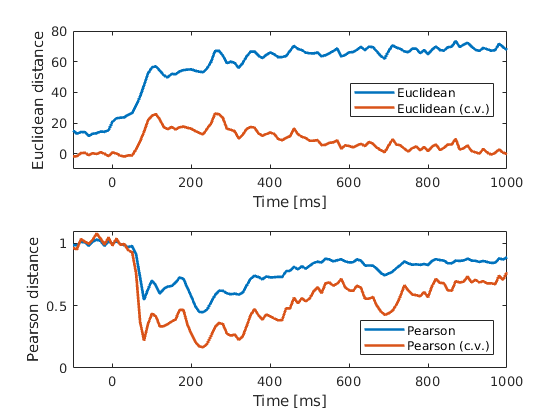

In [9]:
figure;
subplot(211)
hold on
plot(-100:10:1001, squeeze(nanmean(nanmean(nanmean(result.ec, 1), 2), 3)), 'linewidth', 2)
plot(-100:10:1001, squeeze(nanmean(nanmean(nanmean(result_cv.ec_cv, 1), 2), 3)), 'linewidth', 2)
xlim([-100 1000])
ylim([-10 80])
xlabel('Time [ms]')
ylabel('Euclidean distance')
legend('Euclidean', 'Euclidean (c.v.)', 'location', 'East')
box on
subplot(212)
hold on
plot(-100:10:1001, squeeze(nanmean(nanmean(nanmean(result.ps, 1), 2), 3)), 'linewidth', 2)
plot(-100:10:1001, squeeze(nanmean(nanmean(nanmean(result_cv.ps_cv, 1), 2), 3)), 'linewidth', 2)
xlim([-100 1000])
ylim([0 1.1])
xlabel('Time [ms]')
ylabel('Pearson distance')
legend('Pearson', 'Pearson (c.v.)', 'location', 'SouthEast')
box on

**Euclidean distance:** with cross-validation, the Euclidean differences now approaches zero towards the end of an epoch. Thus, cross-validation removes the noise bias, which previously led to high Euclidean distances at the end of a trial despite the absence of true activation pattern differences (as indicated by decoding analyses).

**Pearson distance:** with cross-validation, correlation coefficients increase and thus the Pearson distance (1−r) shows a stronger negative deflection from 1. This result is expected, as 1) cross-validation corrects for effects of noise and 2) noise generally decreases correlation coefficients.